In [128]:
import torch
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from torch import nn as nn
from sklearn.metrics import mean_squared_error

In [7]:
df = pd.read_csv("AMZN_2006-01-01_to_2018-01-01.csv")

In [9]:
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


In [11]:
df['date'] = pd.to_datetime(df['Date'])

In [13]:
timestamp_s = df['date'].map(pd.Timestamp.timestamp)

In [15]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [507]:
#sort the values in ascending to split the data based on timestamp
df = df.sort_values(by ='date')

In [17]:
# drop the unncessary columns
df.drop(["Date",'date','Day cos','Name'],axis =1, inplace = True)

In [19]:
# find the column indices
cols_indices = { name: index for index, name in enumerate(df.columns)}

In [513]:
cols_indices

{'Open': 0,
 'High': 1,
 'Low': 2,
 'Close': 3,
 'Volume': 4,
 'Day sin': 5,
 'Year sin': 6,
 'Year cos': 7}

In [21]:
from sklearn.preprocessing import StandardScaler

In [23]:
SC = StandardScaler()
df_new = pd.DataFrame(SC.fit_transform(df), columns = df.columns)

In [25]:
df_new.head()

,Open,High,Low,Close,Volume,Day sin,Year sin,Year cos
0,-0.899281,-0.903263,-0.898901,-0.899485,0.322272,0.258941,0.059935,1.433402
1,-0.899245,-0.903689,-0.897318,-0.900664,0.294698,1.276993,0.084107,1.432237
2,-0.900388,-0.902021,-0.895806,-0.899235,-0.100456,-1.151384,0.108254,1.430651
3,-0.897496,-0.900672,-0.895051,-0.898449,0.043461,-0.133331,0.132371,1.428646
4,-0.902566,-0.905924,-0.898362,-0.901271,0.588407,-0.525604,0.204468,1.420120


<h2>Split the dataset</h2>

In [27]:
train_data = df_new[:round(.7*len(df_new))]
valid_data = df_new[round(.7*len(df_new)):round(.9*len(df_new))]
test_data = df_new[round(.9*len(df_new)):]

In [29]:
train_data.shape,valid_data.shape, test_data.shape,df_new.shape

((2113, 8), (604, 8), (302, 8), (3019, 8))

<h2>Sequence the inputs based on a window limit</h2>

In [35]:
def splitbyWindow(df_data,window_limit,target_col):
    """The window_limit specifies the i/p sequence used in predicting the output.
    For example if window_limit =3 the closing price from last 3 days are used to predict the 4th day closing price"""
    data, target = [],[]
    total_size = len(df_data)-window_limit
    
    for i in range(total_size):
        data.append(np.array(df_data[i:i+window_limit]))
        
        target.append(np.array(df_data.iloc[i+window_limit][[target_col]]))
        
    data_tensor = torch.tensor(np.array(data))
    target_tensor = torch.tensor(np.array(target)).unsqueeze(1)
    return data_tensor, target_tensor

In [81]:
target_col = 'Close'

#Trying a simple one window 

In [39]:
train_input_tensor, train_label_tensor = splitbyWindow(train_data,1,'Close')
valid_input_tensor, valid_label_tensor = splitbyWindow(valid_data,1,'Close')

In [40]:
train_input_tensor.shape,train_label_tensor.shape, valid_input_tensor.shape, valid_label_tensor.shape

(torch.Size([2112, 1, 8]),
 torch.Size([2112, 1, 1]),
 torch.Size([603, 1, 8]),
 torch.Size([603, 1, 1]))

<h2> Define the dataset and dataloader</h2>

In [43]:
class MyCustomDataset(Dataset):
    def __init__(self, inputs, target):
        self.data = inputs
        self.labels = target
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        return dict(inputs = self.data[idx], labels = self.labels[idx])
        

In [45]:
train_data_ds = MyCustomDataset(train_input_tensor,train_label_tensor)
valid_data_ds = MyCustomDataset(valid_input_tensor,valid_label_tensor)

In [47]:
train_data_ds[0]

{'inputs': tensor([[-0.8993, -0.9033, -0.8989, -0.8995,  0.3223,  0.2589,  0.0599,  1.4334]],
        dtype=torch.float64),
 'labels': tensor([[-0.9007]], dtype=torch.float64)}

In [49]:
train_data_dl = DataLoader(train_data_ds,batch_size = 32,shuffle=True)
valid_data_dl = DataLoader(valid_data_ds,batch_size = 32,shuffle=True)

In [569]:
for nth_batch, test in enumerate(train_data_dl):
    print(nth_batch)
    print(test['inputs'].shape)
    print(test['labels'].shape)
    break

0
torch.Size([32, 1, 8])
torch.Size([32, 1, 1])


<h2> Define the Linear Model</h2>

In [571]:
import torch.nn as nn

In [75]:
class linear_model(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(linear_model,self).__init__()
        #self.input_size = input_size
        self.layer1 = nn.Linear(input_size,hidden_size).to(torch.float64)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size,output_size).to(torch.float64)
    def forward(self, inputs):
        output = self.layer1(inputs)
        output = self.relu(output)
        output = self.layer2(output)
        return output
        

In [71]:
def training_module(dataloader,model,optimizer,loss_fn):
    total_loss = 0.0
    for b_i, data in enumerate(dataloader):
        inputs = data['inputs']
        labels = data['labels']
        outputs = model(inputs)
        #print(outputs.shape)
        loss = loss_fn(outputs,labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss = total_loss + loss.item()
    return total_loss
               

In [73]:
def testing_module(dataloader,model,loss_fn):
    total_mse, total_loss = 0.0, 0.0
    for b_i, data in enumerate(dataloader):
        inputs = data['inputs']
        lables = data['labels']
        with torch.no_grad():
            output = model(inputs)
            loss = loss_fn(output,lables)
            mse = mean_squared_error(output.squeeze(1).detach().numpy(),lables.squeeze(1).detach().numpy())
            total_loss = total_loss + loss.item()
            total_mse = total_mse + mse.item()
            
    return total_loss,total_mse

In [77]:
# Define hyper parameters
linearmodel = linear_model(8,64,1)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(linearmodel.parameters(),lr =0.01)
number_of_epochs =100
best_epoch = -1
best_loss = float('inf')
epochstats = {}
epoch_threshold = 5
for epoch in range(number_of_epochs):
    epochstats[epoch] = {}
    linearmodel.train()
    training_loss = training_module(train_data_dl,linearmodel,optimizer,loss_fn)
    linearmodel.eval()
    validation_loss, validation_mse = testing_module(valid_data_dl,linearmodel,loss_fn)
    epochstats[epoch]["training_loss"] = training_loss
    epochstats[epoch]["validation_loss"] = validation_loss
    #print(f"Epoch {epoch} training loss: {training_loss} validation loss {validation_loss} validation MSE {validation_mse}")
    if validation_loss > best_loss:
        best_loss = validation_loss
        best_epoch = epoch
    elif epoch - best_epoch > epoch_threshold:
        print("Existing before the total epochs",epoch)
        break
    
    
    


Existing before the total epochs 5


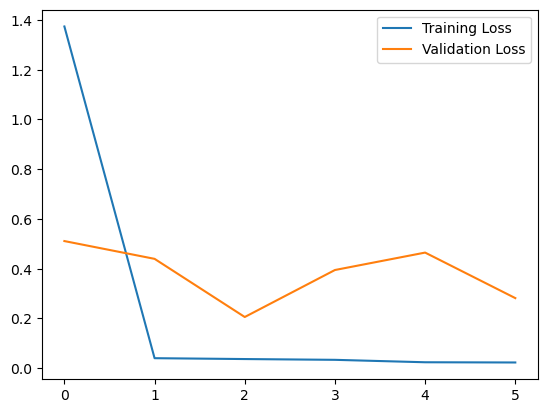

In [583]:
training_loss = [value.get('training_loss') for key,value in epochstats.items() ]
val_loss = [value.get('validation_loss') for key,value in epochstats.items() ]
plt.plot(list(epochstats.keys()),training_loss, label = "Training Loss")
plt.plot(list(epochstats.keys()),val_loss, label = "Validation Loss")
plt.legend()

<h2> Evaluating the test set </h2>

In [585]:
test_input_tensor, test_label_tensor = splitbyWindow(test_data,window_limit,target_col)

In [587]:
test_input_tensor.shape, test_label_tensor.shape

(torch.Size([301, 1, 8]), torch.Size([301, 1, 1]))

In [589]:
with torch.no_grad():
    y_pred = linearmodel(test_input_tensor.squeeze(1))

In [591]:
y_pred.shape

torch.Size([301, 1])

In [593]:
test_label_tensor.shape

torch.Size([301, 1, 1])

In [595]:
y_true = test_label_tensor.squeeze(1)

In [597]:
y_true.squeeze(1)

tensor([1.8252, 1.8562, 1.9244, 1.9140, 1.8691, 1.8540, 1.7038, 1.7520, 1.7362,
        1.6653, 1.6706, 1.6278, 1.7345, 1.7446, 1.6879, 1.5825, 1.5705, 1.4993,
        1.5856, 1.5972, 1.6326, 1.6460, 1.7169, 1.7360, 1.7173, 1.7182, 1.6697,
        1.6545, 1.6118, 1.5871, 1.5752, 1.6432, 1.6623, 1.6827, 1.6717, 1.6764,
        1.6459, 1.6967, 1.6770, 1.6490, 1.6375, 1.6669, 1.6856, 1.6833, 1.6681,
        1.6476, 1.6862, 1.6888, 1.6639, 1.6093, 1.6229, 1.6354, 1.7185, 1.7740,
        1.7774, 1.7737, 1.7849, 1.8371, 1.8496, 1.8231, 1.8151, 1.8207, 1.8181,
        1.8522, 1.8685, 1.9188, 1.9282, 1.9161, 1.8969, 1.8722, 1.9039, 1.9311,
        1.8248, 1.8157, 1.8330, 1.8588, 1.8647, 1.8865, 1.9189, 1.9184, 1.9409,
        1.9460, 1.9494, 1.9900, 1.9870, 1.9748, 1.9500, 1.9621, 1.9493, 1.9780,
        1.9631, 1.9665, 1.9549, 1.9528, 1.9688, 1.9777, 1.9758, 1.9834, 1.9760,
        1.9776, 1.9792, 1.9752, 1.9919, 1.9427, 1.9600, 1.9576, 1.9513, 1.9556,
        1.9884, 2.0539, 2.0611, 2.0975, 

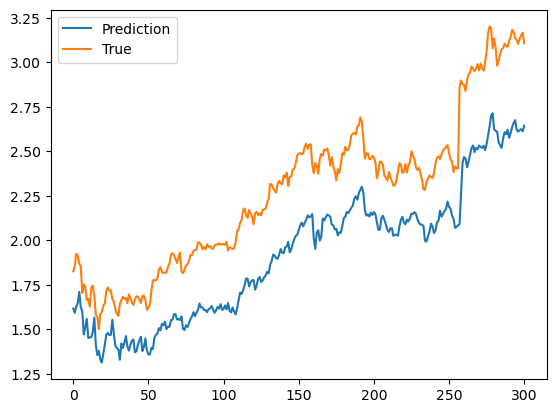

In [599]:
plt.plot(range(len(y_pred)),y_pred.squeeze(1), label ="Prediction")
plt.plot(range(len(y_pred)),y_true.squeeze(1), label ="True")
plt.legend()


<h2> Testing with a different window limit size of 3 i.e. 3 inputs will be used to predict one label. The simple linear network will not work. So need to add an additional layer to flatten. </h2>

In [83]:

train_input_tensor, train_label_tensor = splitbyWindow(train_data,3,target_col)
valid_input_tensor, valid_label_tensor = splitbyWindow(valid_data,3,target_col)

In [84]:
train_input_tensor.shape, train_label_tensor.shape,valid_input_tensor.shape,valid_label_tensor.shape

(torch.Size([2110, 3, 8]),
 torch.Size([2110, 1, 1]),
 torch.Size([601, 3, 8]),
 torch.Size([601, 1, 1]))

In [87]:
train_data_ds = MyCustomDataset(train_input_tensor,train_label_tensor)
valid_data_ds = MyCustomDataset(valid_input_tensor,valid_label_tensor)
train_data_dl = DataLoader(train_data_ds,batch_size = 32,shuffle=True)
valid_data_dl = DataLoader(valid_data_ds,batch_size = 32,shuffle=True)


In [716]:
class flat_linear_model(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(flat_linear_model,self).__init__()
        #self.input_size = input_size
        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(3*8,hidden_size).to(torch.float64)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size,output_size).to(torch.float64)
    def forward(self, inputs):
        #print(inputs.shape)
        flatten_output = self.flatten(inputs)
        #rint(flatten_output.shape)
        output = self.layer1(flatten_output)
        output = self.relu(output)
        output = self.layer2(output)
        return output.unsqueeze(1)
        

In [718]:
# Define hyper parameters
linearmodel = flat_linear_model(8,64,1)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(linearmodel.parameters(),lr =0.01)
number_of_epochs =100
best_epoch = -1
best_loss = float('inf')
epochstats = {}
epoch_threshold = 5
for epoch in range(number_of_epochs):
    epochstats[epoch] = {}
    linearmodel.train()
    training_loss = training_module(train_data_dl,linearmodel,optimizer,loss_fn)
    linearmodel.eval()
    validation_loss, validation_mse = testing_module(valid_data_dl,linearmodel,loss_fn)
    epochstats[epoch]["training_loss"] = training_loss
    epochstats[epoch]["validation_loss"] = validation_loss
    #print(f"Epoch {epoch} training loss: {training_loss} validation loss {validation_loss} validation MSE {validation_mse}")
    if validation_loss > best_loss:
        best_loss = validation_loss
        best_epoch = epoch
    elif epoch - best_epoch > epoch_threshold:
        print("Existing before the total epochs",epoch)
        break
    
    
    


Existing before the total epochs 5


In [720]:
for i in linearmodel.parameters():
    print(i.shape)

torch.Size([64, 24])
torch.Size([64])
torch.Size([1, 64])
torch.Size([1])


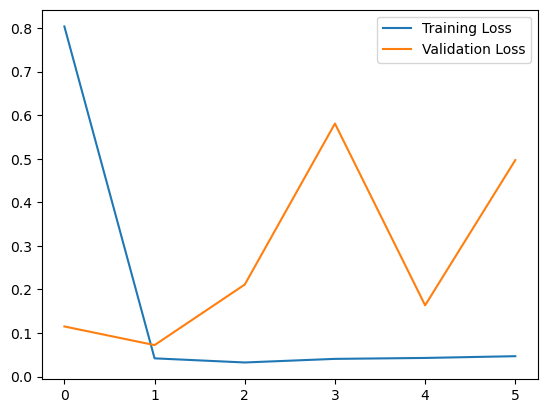

In [722]:
training_loss = [value.get('training_loss') for key,value in epochstats.items() ]
val_loss = [value.get('validation_loss') for key,value in epochstats.items() ]
plt.plot(list(epochstats.keys()),training_loss, label = "Training Loss")
plt.plot(list(epochstats.keys()),val_loss, label = "Validation Loss")
plt.legend()

In [724]:
test_input_tensor, test_label_tensor = splitbyWindow(test_data,3,target_col)

In [726]:
test_label_tensor.shape,test_input_tensor.shape

(torch.Size([299, 1, 1]), torch.Size([299, 3, 8]))

In [728]:
with torch.no_grad():
    y_pred = linearmodel(test_input_tensor)

In [730]:
y_pred[0]

tensor([[1.5875]], dtype=torch.float64)

In [732]:

y_true = test_label_tensor.squeeze(1)

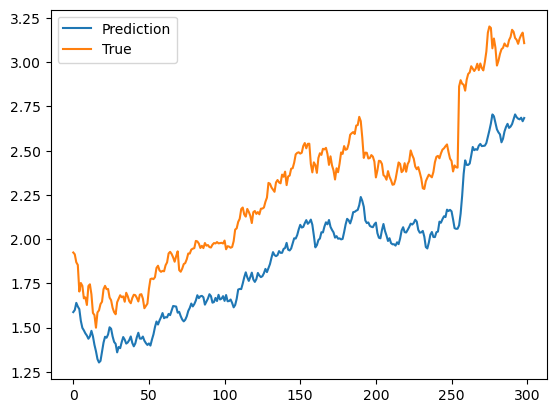

In [734]:
plt.plot(range(len(y_pred)),y_pred.squeeze(1), label ="Prediction")
plt.plot(range(len(y_pred)),y_true.squeeze(1), label ="True")
plt.legend()


<h2> RNN Network</h2>

In [89]:
class rnn_forecast(nn.Module):
    def __init__(self,input_size,hidden_size,output_size,num_of_layers=1):
        super(rnn_forecast, self).__init__()
        self.hidden_size = hidden_size
        self.num_of_layers = num_of_layers
        self.rnn = nn.RNN(input_size,hidden_size,num_layers = self.num_of_layers,batch_first=True).to(torch.float64)
        self.ll = nn.Linear(hidden_size, output_size).to(torch.float64)
    def forward(self,inputs):
        #batch_size = inputs.size(0)
        #self.h0 = torch.zeros(self.num_of_layers,batch_size,self.hidden_size)
        output,_ = self.rnn(inputs)
        output = self.ll(output[:, -1, :])# Pick only the last of the sequences
        return output.unsqueeze(1) # dd new dimension to match the target
        
        
        

In [817]:
model = rnn_forecast(8,128,1)

In [819]:
for i in model.parameters():
    print(i.shape)

torch.Size([128, 8])
torch.Size([128, 128])
torch.Size([128])
torch.Size([128])
torch.Size([1, 128])
torch.Size([1])


In [821]:
# Define hyper parameters

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr =0.01)
number_of_epochs =100
best_epoch = -1
best_loss = float('inf')
epochstats = {}
epoch_threshold = 5
for epoch in range(number_of_epochs):
    epochstats[epoch] = {}
    model.train()
    training_loss = training_module(train_data_dl,model,optimizer,loss_fn)
    model.eval()
    validation_loss, validation_mse = testing_module(valid_data_dl,model,loss_fn)
    epochstats[epoch]["training_loss"] = training_loss
    epochstats[epoch]["validation_loss"] = validation_loss
    #print(f"Epoch {epoch} training loss: {training_loss} validation loss {validation_loss} validation MSE {validation_mse}")
    if validation_loss > best_loss:
        best_loss = validation_loss
        best_epoch = epoch
    elif epoch - best_epoch > epoch_threshold:
        print("Existing before the total epochs",epoch)
        break
    
    
    


Existing before the total epochs 5


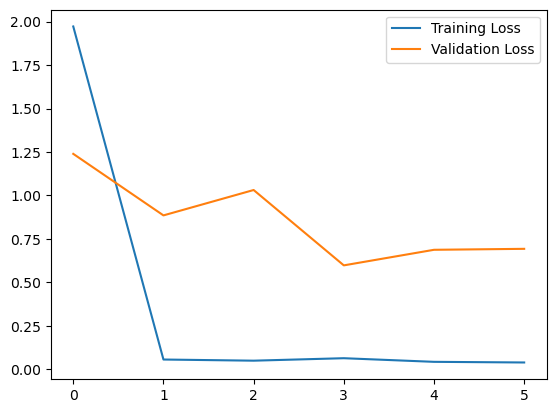

In [823]:
training_loss = [value.get('training_loss') for key,value in epochstats.items() ]
val_loss = [value.get('validation_loss') for key,value in epochstats.items() ]
plt.plot(list(epochstats.keys()),training_loss, label = "Training Loss")
plt.plot(list(epochstats.keys()),val_loss, label = "Validation Loss")
plt.legend()

In [825]:
with torch.no_grad():
    y_pred = model(test_input_tensor)

In [795]:

y_true = test_label_tensor.squeeze(1)

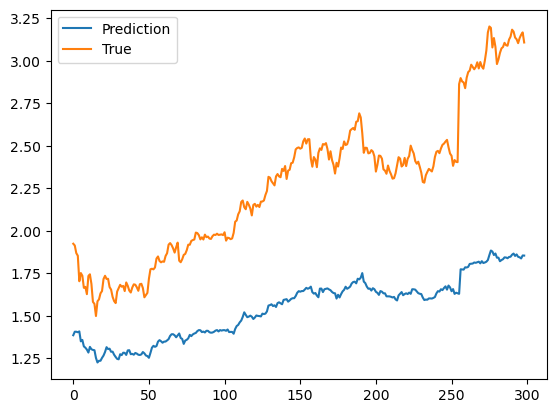

In [827]:
plt.plot(range(len(y_pred)),y_pred.squeeze(1), label ="Prediction")
plt.plot(range(len(y_pred)),y_true.squeeze(1), label ="True")
plt.legend()


In [97]:
# Define hyper parameters
model = rnn_forecast(8,32,1,2)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr =0.01)
number_of_epochs =100
best_epoch = -1
best_loss = float('inf')
epochstats = {}
epoch_threshold = 10
for epoch in range(number_of_epochs):
    epochstats[epoch] = {}
    model.train()
    training_loss = training_module(train_data_dl,model,optimizer,loss_fn)
    model.eval()
    validation_loss, validation_mse = testing_module(valid_data_dl,model,loss_fn)
    epochstats[epoch]["training_loss"] = training_loss
    epochstats[epoch]["validation_loss"] = validation_loss
    #print(f"Epoch {epoch} training loss: {training_loss} validation loss {validation_loss} validation MSE {validation_mse}")
    if validation_loss < best_loss:
        best_loss = validation_loss
        best_epoch = epoch
    elif epoch - best_epoch > epoch_threshold:
        print("Existing before the total epochs",epoch)
        break
    
    
    


Existing before the total epochs 27


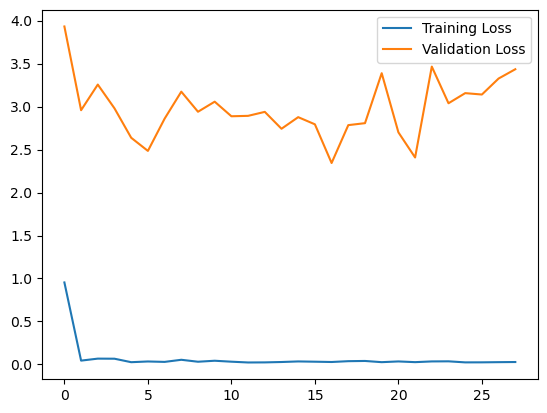

In [99]:
training_loss = [value.get('training_loss') for key,value in epochstats.items() ]
val_loss = [value.get('validation_loss') for key,value in epochstats.items() ]
plt.plot(list(epochstats.keys()),training_loss, label = "Training Loss")
plt.plot(list(epochstats.keys()),val_loss, label = "Validation Loss")
plt.legend()

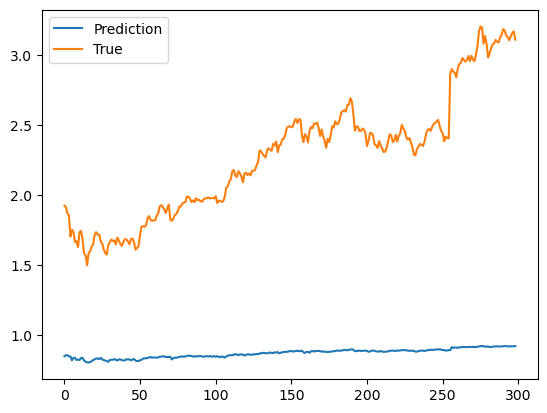

In [109]:
test_input_tensor, test_label_tensor = splitbyWindow(test_data,3,target_col)
with torch.no_grad():
    y_pred = model(test_input_tensor)

y_true = test_label_tensor.squeeze(1)
plt.plot(range(len(y_pred)),y_pred.squeeze(1), label ="Prediction")
plt.plot(range(len(y_pred)),y_true.squeeze(1), label ="True")
plt.legend()


<h2>Use different hyper parameters</h2>

In [120]:
# Define hyper parameters
model = rnn_forecast(8,128,1,2)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),lr =0.03,momentum =0.9)
number_of_epochs =100
best_epoch = -1
best_loss = float('inf')
epochstats = {}
epoch_threshold = 10
for epoch in range(number_of_epochs):
    epochstats[epoch] = {}
    model.train()
    training_loss = training_module(train_data_dl,model,optimizer,loss_fn)
    model.eval()
    validation_loss, validation_mse = testing_module(valid_data_dl,model,loss_fn)
    epochstats[epoch]["training_loss"] = training_loss
    epochstats[epoch]["validation_loss"] = validation_loss
    #print(f"Epoch {epoch} training loss: {training_loss} validation loss {validation_loss} validation MSE {validation_mse}")
    if validation_loss < best_loss:
        best_loss = validation_loss
        best_epoch = epoch
    elif epoch - best_epoch > epoch_threshold:
        print("Existing before the total epochs",epoch)
        break
    
    
    


Existing before the total epochs 62


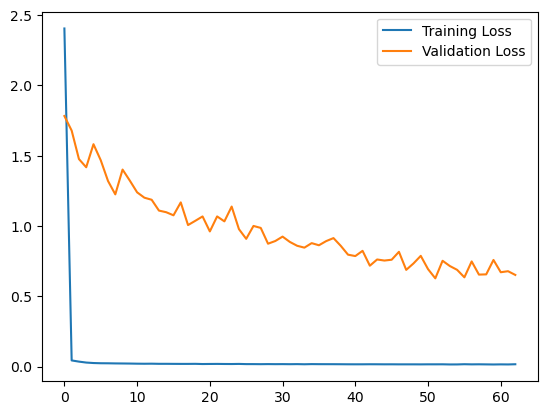

In [122]:
training_loss = [value.get('training_loss') for key,value in epochstats.items() ]
val_loss = [value.get('validation_loss') for key,value in epochstats.items() ]
plt.plot(list(epochstats.keys()),training_loss, label = "Training Loss")
plt.plot(list(epochstats.keys()),val_loss, label = "Validation Loss")
plt.legend()

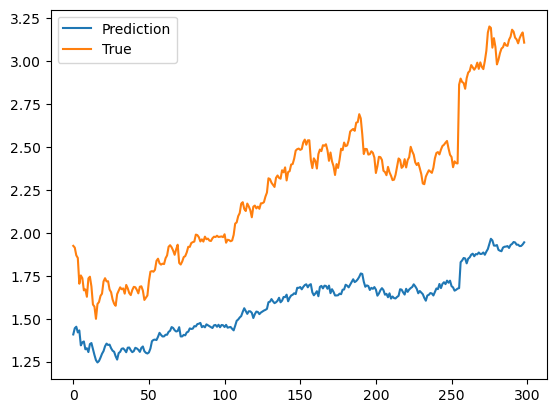

In [124]:
test_input_tensor, test_label_tensor = splitbyWindow(test_data,3,target_col)
with torch.no_grad():
    y_pred = model(test_input_tensor)

y_true = test_label_tensor.squeeze(1)
plt.plot(range(len(y_pred)),y_pred.squeeze(1), label ="Prediction")
plt.plot(range(len(y_pred)),y_true.squeeze(1), label ="True")
plt.legend()


In [130]:
mean_squared_error(y_pred.squeeze(1).detach().numpy(),y_true.squeeze(1).detach().numpy())

0.5376753768470136

<h2>Use different hyper parameters</h2>

In [132]:
# Define hyper parameters
model = rnn_forecast(8,128,1,2)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),lr =0.03)
number_of_epochs =100
best_epoch = -1
best_loss = float('inf')
epochstats = {}
epoch_threshold = 10
for epoch in range(number_of_epochs):
    epochstats[epoch] = {}
    model.train()
    training_loss = training_module(train_data_dl,model,optimizer,loss_fn)
    model.eval()
    validation_loss, validation_mse = testing_module(valid_data_dl,model,loss_fn)
    epochstats[epoch]["training_loss"] = training_loss
    epochstats[epoch]["validation_loss"] = validation_loss
    #print(f"Epoch {epoch} training loss: {training_loss} validation loss {validation_loss} validation MSE {validation_mse}")
    if validation_loss < best_loss:
        best_loss = validation_loss
        best_epoch = epoch
    elif epoch - best_epoch > epoch_threshold:
        print("Existing before the total epochs",epoch)
        break

Existing before the total epochs 20


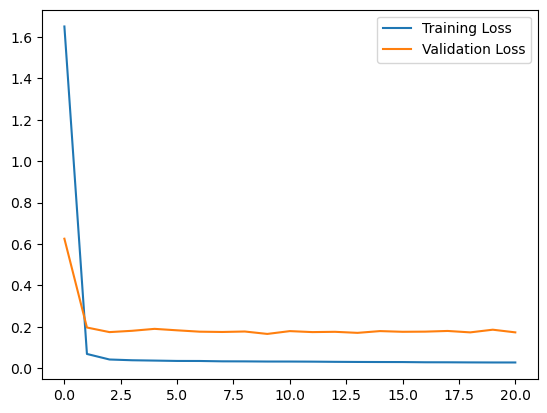

In [134]:
training_loss = [value.get('training_loss') for key,value in epochstats.items() ]
val_loss = [value.get('validation_loss') for key,value in epochstats.items() ]
plt.plot(list(epochstats.keys()),training_loss, label = "Training Loss")
plt.plot(list(epochstats.keys()),val_loss, label = "Validation Loss")
plt.legend()

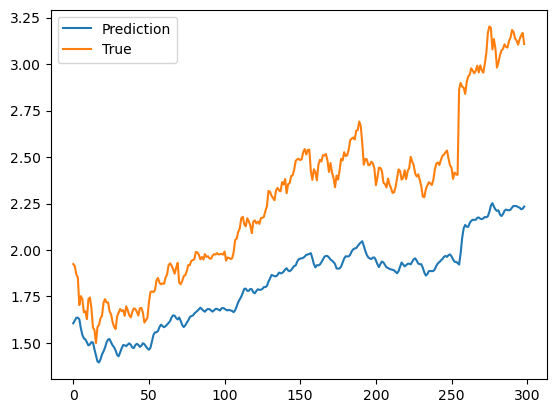

In [136]:
test_input_tensor, test_label_tensor = splitbyWindow(test_data,3,target_col)
with torch.no_grad():
    y_pred = model(test_input_tensor)

y_true = test_label_tensor.squeeze(1)
plt.plot(range(len(y_pred)),y_pred.squeeze(1), label ="Prediction")
plt.plot(range(len(y_pred)),y_true.squeeze(1), label ="True")
plt.legend()


In [138]:
mean_squared_error(y_pred.squeeze(1).detach().numpy(),y_true.squeeze(1).detach().numpy())

0.24832926013067988

In [142]:
# Define hyper parameters
model = rnn_forecast(8,128,1,2)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),lr =0.01)
number_of_epochs =100
best_epoch = -1
best_loss = float('inf')
epochstats = {}
epoch_threshold = 10
for epoch in range(number_of_epochs):
    epochstats[epoch] = {}
    model.train()
    training_loss = training_module(train_data_dl,model,optimizer,loss_fn)
    model.eval()
    validation_loss, validation_mse = testing_module(valid_data_dl,model,loss_fn)
    epochstats[epoch]["training_loss"] = training_loss
    epochstats[epoch]["validation_loss"] = validation_loss
    #print(f"Epoch {epoch} training loss: {training_loss} validation loss {validation_loss} validation MSE {validation_mse}")
    if validation_loss < best_loss:
        best_loss = validation_loss
        best_epoch = epoch
    elif epoch - best_epoch > epoch_threshold:
        print("Existing before the total epochs",epoch)
        break

Existing before the total epochs 90


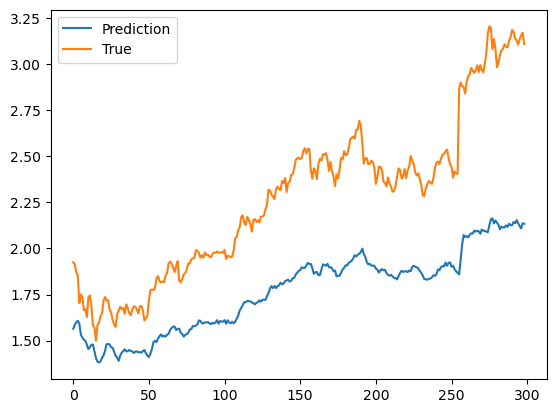

In [144]:
test_input_tensor, test_label_tensor = splitbyWindow(test_data,3,target_col)
with torch.no_grad():
    y_pred = model(test_input_tensor)

y_true = test_label_tensor.squeeze(1)
plt.plot(range(len(y_pred)),y_pred.squeeze(1), label ="Prediction")
plt.plot(range(len(y_pred)),y_true.squeeze(1), label ="True")
plt.legend()


In [146]:
mean_squared_error(y_pred.squeeze(1).detach().numpy(),y_true.squeeze(1).detach().numpy())

0.3093134207202471

In [148]:
# Define hyper parameters
model = rnn_forecast(8,128,1,2)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr =0.001)
number_of_epochs =100
best_epoch = -1
best_loss = float('inf')
epochstats = {}
epoch_threshold = 10
for epoch in range(number_of_epochs):
    epochstats[epoch] = {}
    model.train()
    training_loss = training_module(train_data_dl,model,optimizer,loss_fn)
    model.eval()
    validation_loss, validation_mse = testing_module(valid_data_dl,model,loss_fn)
    epochstats[epoch]["training_loss"] = training_loss
    epochstats[epoch]["validation_loss"] = validation_loss
    #print(f"Epoch {epoch} training loss: {training_loss} validation loss {validation_loss} validation MSE {validation_mse}")
    if validation_loss < best_loss:
        best_loss = validation_loss
        best_epoch = epoch
    elif epoch - best_epoch > epoch_threshold:
        print("Existing before the total epochs",epoch)
        break

Existing before the total epochs 15


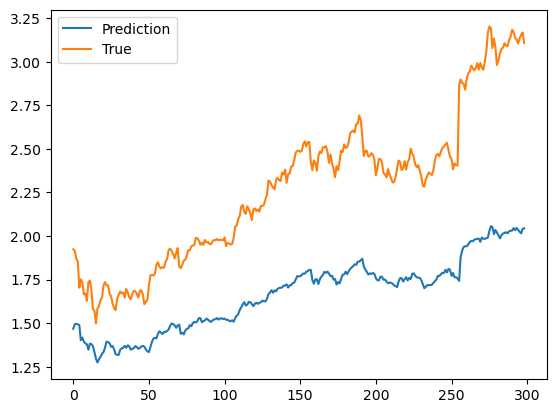

In [150]:
test_input_tensor, test_label_tensor = splitbyWindow(test_data,3,target_col)
with torch.no_grad():
    y_pred = model(test_input_tensor)

y_true = test_label_tensor.squeeze(1)
plt.plot(range(len(y_pred)),y_pred.squeeze(1), label ="Prediction")
plt.plot(range(len(y_pred)),y_true.squeeze(1), label ="True")
plt.legend()


In [152]:
mean_squared_error(y_pred.squeeze(1).detach().numpy(),y_true.squeeze(1).detach().numpy())

0.427704710437264

In [154]:
optimizer.state_dict()

{'state': {0: {'step': tensor(1056.),
   'exp_avg': tensor([[ 1.7787e-05,  2.1176e-05,  2.1253e-05,  ...,  7.3993e-05,
             6.3459e-05, -2.9110e-05],
           [ 6.7441e-06,  7.8627e-06,  7.7918e-06,  ...,  2.3887e-05,
             2.6523e-05, -4.4687e-06],
           [ 8.8833e-07, -6.3053e-07, -9.8474e-07,  ...,  3.3862e-05,
             5.9276e-06, -1.6075e-07],
           ...,
           [ 1.6122e-05,  1.7657e-05,  1.7320e-05,  ...,  9.5084e-05,
             5.9168e-05, -1.5364e-05],
           [-1.7347e-05, -2.1527e-05, -2.2134e-05,  ..., -5.0665e-05,
            -7.8363e-05,  1.0771e-05],
           [ 5.1089e-05,  5.8674e-05,  6.0098e-05,  ...,  5.3576e-07,
             2.2747e-04, -3.8380e-05]], dtype=torch.float64),
   'exp_avg_sq': tensor([[3.6268e-07, 3.6403e-07, 3.6173e-07,  ..., 1.1640e-07, 2.3218e-07,
            1.4348e-07],
           [2.4074e-07, 2.4182e-07, 2.4152e-07,  ..., 3.4905e-08, 9.8883e-08,
            8.4754e-08],
           [7.5637e-07, 7.5901e-07, 7.

In [184]:
optimizer.state_dict()['state'][0]['exp_avg']

torch.Size([128, 8])

In [188]:
for i in model.parameters():
    print(i.shape)

torch.Size([128, 8])
torch.Size([128, 128])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128, 128])
torch.Size([128])
torch.Size([128])
torch.Size([1, 128])
torch.Size([1])


In [187]:
model.state_dict()

OrderedDict([('rnn.weight_ih_l0',
              tensor([[-0.0577,  0.0036, -0.0556,  ..., -0.0639, -0.0826, -0.0391],
                      [-0.0022, -0.0108, -0.0619,  ...,  0.0079, -0.0508,  0.0199],
                      [ 0.0215, -0.0626, -0.0144,  ...,  0.0511, -0.0022,  0.0075],
                      ...,
                      [ 0.0134,  0.0348, -0.0573,  ...,  0.0219,  0.0117, -0.0499],
                      [ 0.0079,  0.0832,  0.0167,  ..., -0.0511,  0.0286, -0.0037],
                      [-0.0540,  0.0145, -0.0606,  ..., -0.0400,  0.0683,  0.0238]],
                     dtype=torch.float64)),
             ('rnn.weight_hh_l0',
              tensor([[-0.0691,  0.0732,  0.0453,  ..., -0.0267, -0.0025, -0.0179],
                      [-0.0378, -0.0584,  0.0718,  ..., -0.0225,  0.0079, -0.0385],
                      [-0.0394, -0.0054,  0.0067,  ...,  0.0088, -0.0100,  0.0083],
                      ...,
                      [-0.0543,  0.0708,  0.0385,  ..., -0.0806, -0.0562,  0.